In [41]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append('..')

import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error

In [42]:
import os
pathdata = 'datasets/'
pathresults = 'results'
if not os.path.exists(pathresults):
    os.makedirs(pathresults)

## MODELOS Y ESCENARIO A EVALUAR

In [43]:
models = ['BCC_126', 'BCC_370', 'BCC_585', 'CNRM_126', 'CNRM_370','CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585']

## **LENTEJAS EVALUADAS POR SU RESISTENCIA A LA ROYA**

## Load Data Lentejas Roya: Temperatura y Precipitación

In [44]:
roya_raw = pd.read_csv(pathdata+"DatosPrecip/ROYA_Completa_fut_pres.txt",decimal=',',sep= '\t')

# Me quedo solo con las columnas de latitud, longitud, predicciones de bio_1 y bio_12 para el presente y el futuro
cols_to_drop = list(roya_raw.columns[0:5]) + list(roya_raw.columns[[7, 8, 9, 10]])
roya_raw = roya_raw.drop(cols_to_drop, axis = 1)

# Renombro y transformo a float las columnas para mantener el mismo formato en todos los datasets
roya_raw = roya_raw.rename(columns={'Longitude': 'DECLONGITUDE', 'Latitude': 'DECLATITUDE'})
roya_raw = roya_raw.applymap(lambda x: float(x))

roya_raw[['BBC_126', 'BBC_370', 'BBC_585', 'CNRM_126', 'CNRM_370','CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585']] = roya_raw[['BBC_126', 'BBC_370', 'BBC_585', 'CNRM_126', 'CNRM_370','CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585']].applymap(lambda x: x*10)
roya_raw.drop_duplicates(inplace = True)

roya_raw.head(1)

,DECLATITUDE,DECLONGITUDE,BBC_126,BBC_370,BBC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,...,BCC_370_B12,BCC_585_B12,IPSL_126_B12,IPSL_370_B12,IPSL_585_B12,CNRM_126_B12,CNRM_370_B12,CNRM_585_B12,CURRENT_BIO1,CURRENT_BIO12
0,37.491944,-2.773611,152.875004,155.166664,157.624998,154.458332,153.374996,154.958334,155.333328,155.749998,...,402.0,389.0,375.0,377.0,366.0,393.0,386.0,380.0,142.839996,443.359985


In [45]:
print(roya_raw.shape)

(247, 22)


## Load Data Lentejas Roya: radiación, condiciones del suelo y DSR

In [46]:
# Cargamos el dataset con todas las variables de radiación, condiciones del suelo, DSR y coordenadas para las lentejas
# evaluadas por su resistencia la roya en el presente.

roya = pd.read_csv(pathdata+"DatosPresente/fichtraining_ROYA_CAMPO_nondup.csv",decimal=',',sep=';',)
roya = roya[['srad_12', 'srad_annual', 't_bulk_dens', 't_sand', 't_soilwater_cap', 't_teb', 'DECLONGITUDE','DECLATITUDE','ROYA_CAMPO_AVERAGE_DSR']]

roya.head(1)

,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb,DECLONGITUDE,DECLATITUDE,ROYA_CAMPO_AVERAGE_DSR
0,5194,14868.75,1451.699951,37.0,23.700001,28.799999,5.133333,43.916667,0.0


In [47]:
print(roya.shape)

(255, 9)


## Dataset Lentejas Roya Presente

In [48]:
# Unimos las condiciones de radiación y el suelo, con el valor de temperatura y precipitación para el presente.

roya_presente = pd.merge(roya_raw[['DECLONGITUDE','DECLATITUDE','CURRENT_BIO1', 'CURRENT_BIO12']],roya, how='inner', on = ['DECLONGITUDE','DECLATITUDE'])
roya_presente.drop_duplicates(subset = ['DECLONGITUDE','DECLATITUDE'], inplace = True)
roya_presente.head()

,DECLONGITUDE,DECLATITUDE,CURRENT_BIO1,CURRENT_BIO12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb,ROYA_CAMPO_AVERAGE_DSR
0,-2.773611,37.491944,142.839996,443.359985,7587,17020.333984,1501.800049,34.000000,21.549999,19.799999,58.293233
1,-5.270000,37.786944,178.600006,605.280029,7271,16987.083984,1526.949951,36.880001,22.775000,23.476000,61.787905
2,-17.758611,28.797222,191.125000,370.312500,10670,18398.333984,1358.599976,47.000000,26.575001,10.000000,70.940348
3,-3.956667,37.768889,165.479996,563.799988,7406,16711.083984,1518.650024,33.959999,23.549999,26.976000,77.256578
4,-4.855556,42.221667,116.400002,489.720001,4885,14776.583008,1515.974976,19.000000,21.000000,46.599998,72.408651


In [49]:
print(roya_presente.shape)

(247, 11)


## Dataset Lentejas Roya Futuro

In [50]:
# Unimos las condiciones de radiación y el suelo, con el valor de temperatura y precipitación para el presente.

roya_futuro = pd.merge(roya_raw[roya_raw.columns[0:20]],roya, how='inner', on = ['DECLONGITUDE','DECLATITUDE'])
roya_futuro = roya_futuro.rename(columns={'BBC_126': 'BCC_126', 'BBC_370': 'BCC_370', 'BBC_585': 'BCC_585'})
roya_futuro.drop_duplicates(subset = ['DECLONGITUDE','DECLATITUDE'], inplace = True)
roya_futuro.head()

,DECLATITUDE,DECLONGITUDE,BCC_126,BCC_370,BCC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,...,CNRM_126_B12,CNRM_370_B12,CNRM_585_B12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb,ROYA_CAMPO_AVERAGE_DSR
0,37.491944,-2.773611,152.875004,155.166664,157.624998,154.458332,153.374996,154.958334,155.333328,155.749998,...,393.0,386.0,380.0,7587,17020.333984,1501.800049,34.000000,21.549999,19.799999,58.293233
1,37.786944,-5.270000,187.000008,189.083328,192.333336,188.500004,187.625008,188.999996,188.833332,189.166660,...,527.0,523.0,515.0,7271,16987.083984,1526.949951,36.880001,22.775000,23.476000,61.787905
2,28.797222,-17.758611,195.000000,195.958328,197.875004,198.333340,198.624992,198.958340,197.333336,197.875004,...,328.0,320.0,315.0,10670,18398.333984,1358.599976,47.000000,26.575001,10.000000,70.940348
3,37.768889,-3.956667,175.750008,178.125000,180.916672,177.208328,176.291676,177.916660,178.083344,178.416672,...,471.0,460.0,459.0,7406,16711.083984,1518.650024,33.959999,23.549999,26.976000,77.256578
4,42.221667,-4.855556,128.208332,131.041670,134.041672,130.500002,129.291668,130.333338,131.916666,132.958336,...,468.0,455.0,460.0,4885,14776.583008,1515.974976,19.000000,21.000000,46.599998,72.408651


In [51]:
print(roya_futuro.shape)

(247, 27)


# LENTEJAS SILVESTRES

## Dataset Lentejas Silvestres Presente

In [52]:
lentejas_silvestres = pd.read_excel(pathdata+"DatosPresente/SupplementaryTable3_RubioTeso_etal_Martonne_bio12.xlsx")

# Renombro y transformo las columnas (la temperatura se debe multiplicar por 10 para estar en el mismo orden) para 
# mantener el mismo formato en todos los datasets
lentejas_silvestres = lentejas_silvestres.rename(columns={'Longitude_decimal': 'DECLONGITUDE', 'Latitude_decimal': 'DECLATITUDE', 'bio_12' : 'CURRENT_BIO12'})
lentejas_silvestres['CURRENT_BIO1'] = lentejas_silvestres.bio_1.apply(lambda x: x*10)
lentejas_silvestres.drop('bio_1', axis = 1, inplace = True)

lentejas_silvestres = lentejas_silvestres[['DECLONGITUDE','DECLATITUDE','CURRENT_BIO1','CURRENT_BIO12','srad_12', 'srad_annual', 't_bulk_dens', 't_sand', 't_soilwater_cap','t_teb']]
lentejas_silvestres.drop_duplicates(subset = ['DECLONGITUDE','DECLATITUDE'], inplace = True)
lentejas_silvestres.dropna(inplace = True)

lentejas_silvestres.head()

,DECLONGITUDE,DECLATITUDE,CURRENT_BIO1,CURRENT_BIO12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb
0,22.502781,38.523891,99.448338,800.0,0.5364,14913.33301,1422.625000,28.0,23.950001,37.599998
1,33.700000,44.650000,107.978334,496.0,0.5352,13129.16699,1484.375000,21.0,23.825001,22.900000
2,33.716667,44.483333,94.020004,571.0,0.5124,13137.33301,1451.250000,23.0,24.150000,22.100000
3,34.582500,41.724720,80.598335,676.0,0.4556,14525.75000,1402.900024,38.0,23.650000,27.100000
4,37.200000,37.100000,140.310001,580.0,0.5284,17900.00000,1502.800049,26.0,24.900000,13.400000


In [53]:
lentejas_silvestres.shape

(613, 10)

## Dataset Lentejas Silvestres Futuro

In [54]:
silv_futuro = pd.read_csv(pathdata+"DatosPrecip/Len_silvestres_futuro_B1_B12.txt",decimal=',',sep= '\t')

# Me quedo sólo con las columnas relativas a las predicciones de bio_1 y bio_12 de los escenarios futuros
silv_futuro = silv_futuro[['bbc_126', 'bbc_370', 'bbc_585',
       'CNRM_126', 'CNRM_370', 'CNRM_585', 'IPSL_126', 'IPSL_370', 'IPSL_585',
       'BBC_126_B12', 'BBC_370_B12', 'BBC_585_B12', 'IPSL_126_B12',
       'IPSL_370_B12', 'IPSL_585_B12', 'CNRM_126_B12', 'CNRM_370_B12',
       'CNRM_585_B12',"DECLATITUD", "DECLONGITU"]]

# Renombro y transformo a float columnas para mantener el mismo formato en todos los datasets
silv_futuro = silv_futuro.rename(columns={'DECLONGITU': 'DECLONGITUDE', 'DECLATITUD': 'DECLATITUDE','bbc_126': 'BCC_126', 'bbc_370': 'BCC_370', 'bbc_585': 'BCC_585','BBC_126_B12':'BCC_126_B12', 'BBC_370_B12':'BCC_370_B12', 'BBC_585_B12':'BCC_585_B12'})
silv_futuro = silv_futuro.applymap(lambda x: float(x))

# La temperatura se debe multiplicar por 10 para estar en el mismo orden en todos los datasets. Descarto posibles duplicados
# en cuanto a las coordenadas y valores nulos
silv_futuro[models] = silv_futuro[models].applymap(lambda x: x * 10)
silv_futuro.drop_duplicates(subset = ['DECLONGITUDE','DECLATITUDE'], inplace = True)
silv_futuro.dropna(inplace = True)

# Para poder disponer de las condiciones de radiación, suelo... Extraigo esos valores del dataset de lentejas silvestres
# en el presente mediante el merge
silvest_futuro = pd.merge(silv_futuro,lentejas_silvestres, how='inner', on = ['DECLONGITUDE','DECLATITUDE'])
silvest_futuro.head()

,BCC_126,BCC_370,BCC_585,CNRM_126,CNRM_370,CNRM_585,IPSL_126,IPSL_370,IPSL_585,BCC_126_B12,...,DECLATITUDE,DECLONGITUDE,CURRENT_BIO1,CURRENT_BIO12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb
0,119.000006,117.958336,119.875002,115.958338,114.624996,118.333330,115.958328,116.833334,113.458338,584.0,...,44.404167,33.825000,108.059521,562.0,0.554286,12971.75000,1420.675049,0.0,24.950001,0.0
1,179.874992,181.124992,182.500000,181.333332,179.791660,182.666664,181.333332,182.124996,180.708332,657.0,...,40.063611,18.466389,167.154770,658.0,0.920000,15401.50000,1487.474976,27.0,22.875000,13.4
2,147.125006,148.083334,150.249996,149.375000,147.458334,150.375004,148.291664,148.958330,147.791662,703.0,...,38.083300,28.200000,143.915005,688.0,0.636400,17663.41602,1498.675049,80.0,22.325001,10.4
3,161.875000,163.708324,165.541668,163.541660,162.124996,164.624996,163.541660,164.291668,162.666664,584.0,...,40.600000,17.150000,149.216671,584.0,0.838800,15037.66699,1488.724976,42.0,24.775000,14.0
4,126.250000,128.750000,131.875000,127.791672,126.000004,128.874998,127.458334,129.250002,126.416664,1082.0,...,45.500000,15.570600,110.120001,1041.0,0.548800,12406.50000,1445.849976,79.0,23.600000,11.0


In [55]:
silvest_futuro.shape
silvest_futuro.to_excel(pathresults+"/silvest_data_future_RF.xlsx", index=False)

## CORRELATION FEATURES

In [56]:
correlation_matrix = roya_presente.drop('ROYA_CAMPO_AVERAGE_DSR', axis = 1).corr()
correlation_matrix


,DECLONGITUDE,DECLATITUDE,CURRENT_BIO1,CURRENT_BIO12,srad_12,srad_annual,t_bulk_dens,t_sand,t_soilwater_cap,t_teb
DECLONGITUDE,1.000000,0.211403,0.331774,0.014496,-0.043691,0.303088,0.352558,0.051538,0.013536,-0.063691
DECLATITUDE,0.211403,1.000000,-0.358426,-0.207454,-0.936087,-0.375234,0.351286,-0.152099,-0.379274,0.178811
CURRENT_BIO1,0.331774,-0.358426,1.000000,-0.102323,0.577892,0.755834,0.343480,-0.018231,0.238762,-0.042898
CURRENT_BIO12,0.014496,-0.207454,-0.102323,1.000000,0.133586,-0.296070,-0.491960,0.123345,0.293647,-0.319135
srad_12,-0.043691,-0.936087,0.577892,0.133586,1.000000,0.628119,-0.242206,0.167662,0.406640,-0.180623
srad_annual,0.303088,-0.375234,0.755834,-0.296070,0.628119,1.000000,0.229978,-0.019759,0.324322,0.034430
t_bulk_dens,0.352558,0.351286,0.343480,-0.491960,-0.242206,0.229978,1.000000,-0.363609,-0.365675,0.411944
t_sand,0.051538,-0.152099,-0.018231,0.123345,0.167662,-0.019759,-0.363609,1.000000,0.055336,-0.798312
t_soilwater_cap,0.013536,-0.379274,0.238762,0.293647,0.406640,0.324322,-0.365675,0.055336,1.000000,-0.199651
t_teb,-0.063691,0.178811,-0.042898,-0.319135,-0.180623,0.034430,0.411944,-0.798312,-0.199651,1.000000


<AxesSubplot:>

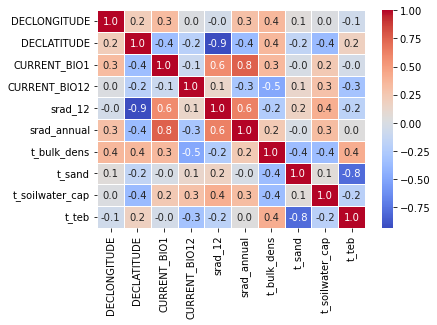

In [57]:
sns.heatmap(correlation_matrix, xticklabels=list(correlation_matrix), yticklabels=list(correlation_matrix), annot=True, fmt='.1f', linewidths = 0.5, cmap="coolwarm")

## CORRELATION TARGET

In [61]:
correlation_target = roya_presente.corr()['ROYA_CAMPO_AVERAGE_DSR'].drop('ROYA_CAMPO_AVERAGE_DSR')
correlation_target

DECLONGITUDE      -0.265087
DECLATITUDE        0.143264
CURRENT_BIO1      -0.136595
CURRENT_BIO12     -0.269608
srad_12           -0.174746
srad_annual       -0.083779
t_bulk_dens        0.150505
t_sand            -0.201992
t_soilwater_cap   -0.269986
t_teb              0.224984
Name: ROYA_CAMPO_AVERAGE_DSR, dtype: float64

C:\Users\rt01115\AppData\Local\Temp/ipykernel_21256/3793168650.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(correlation_target.index, rotation=45)


Text(0.5, 1.0, 'Feature Correlation with Target Variable')

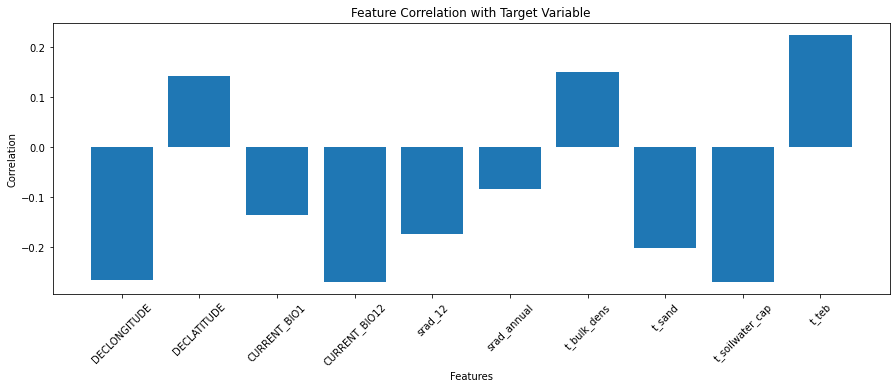

In [65]:
plt.rc('figure', figsize=(15, 5))


_, ax = plt.subplots()
ax.bar(correlation_target.index, correlation_target.values)

ax.set_xlabel('Features')
ax.set_ylabel('Correlation')
ax.set_xticklabels(correlation_target.index, rotation=45)
ax.set_title('Feature Correlation with Target Variable')